In this notebook the evolution of the concetration of NO2 in the city of Madrid, Spain in the period of January-April 2020 will be studied.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
pollutant = 'NO2'

In [3]:
df = pd.read_csv('../clean_datasets/%s-2020.csv'%(pollutant), index_col=0, parse_dates=True)

In [4]:
df.head()

,estacion,concentracion
dt,,
2020-01-01,39,126.0
2020-01-01,16,71.0
2020-01-01,40,107.0
2020-01-01,47,67.0
2020-01-01,11,104.0


I'll be working with the average concentration throughout all stations per hour.

In [5]:
df = df.groupby('dt')['concentracion'].mean()
df = pd.DataFrame(df)

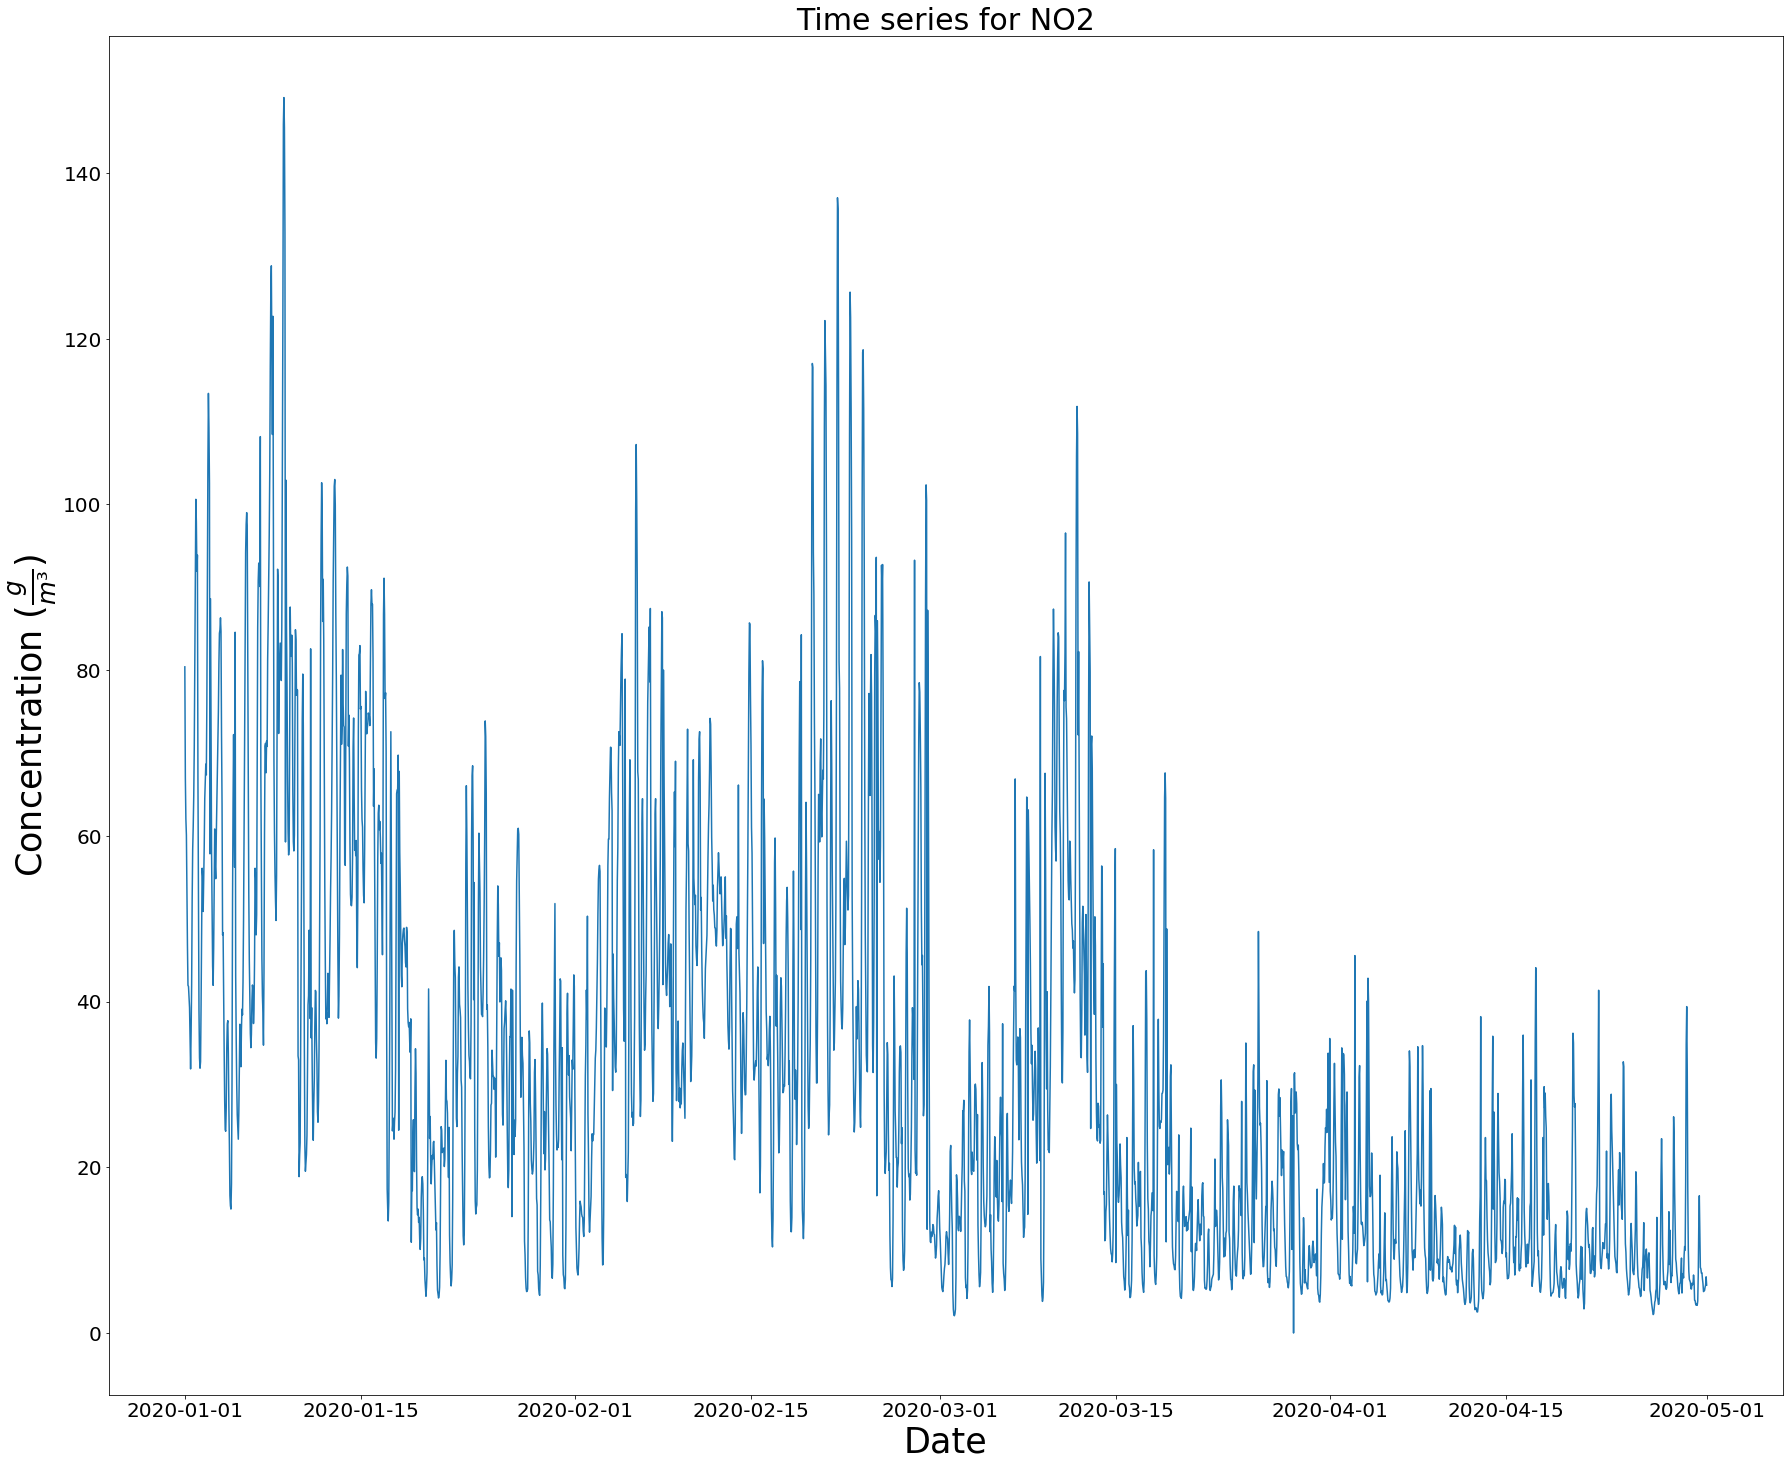

In [6]:
plt.figure(figsize=(30,25))
sns.lineplot(df.index, df['concentracion'])
plt.xlabel('Date', fontsize=35)
plt.ylabel(r'Concentration $(\frac{g}{m³})$', fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Time series for ' + pollutant, fontsize=30);

I'll use a simple moving average to smooth out the curve.

In [7]:
df['SMA'] = df.loc[:,'concentracion'].rolling(window = 24,
                                                min_periods = 1).mean()

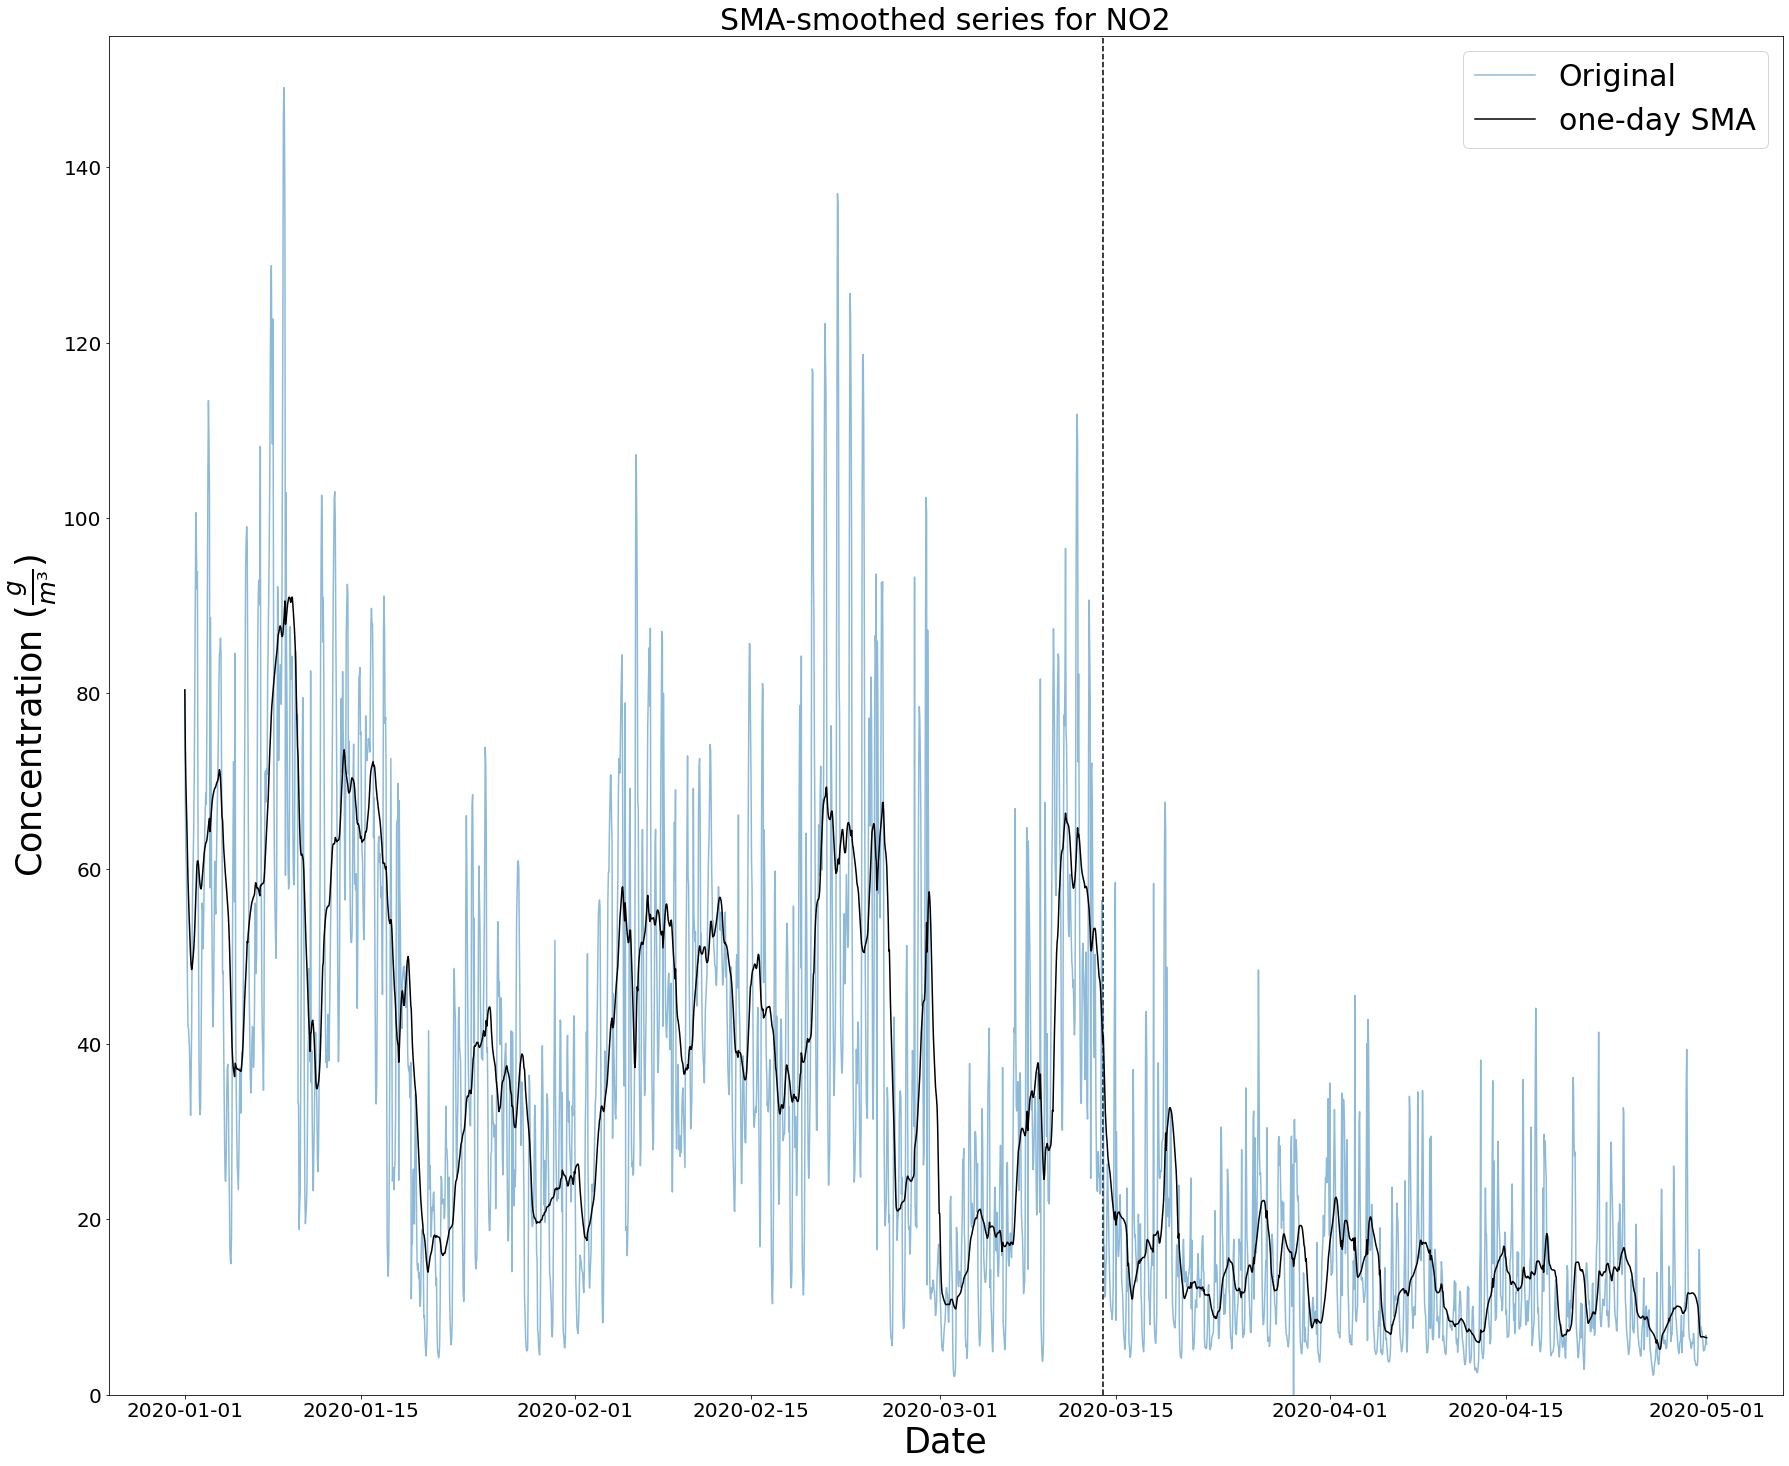

In [8]:
lockdown = dt.datetime(2020,3,14)

plt.figure(figsize=(30,25))
#sns.lineplot(df.index, df['concentracion'], color='blue', linestyle= ,label='original')
plt.plot(df.index, df['concentracion'], label='Original', alpha=0.5)
plt.plot(df.index, df['SMA'], label='one-day SMA', color='black')
plt.xlabel('Date', fontsize=35)
plt.ylabel(r'Concentration $(\frac{g}{m³})$', fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,155)
#plt.grid(color = 'black')
plt.title('SMA-smoothed series for ' + pollutant, fontsize=30)
plt.legend(fontsize=30)
plt.vlines(lockdown, ymin = 0, ymax = 155, linestyle='--');

The dotted line corresponds to March 14, when the lockdown was officially initiated. It can be seen that it is around this date that the concentration levels plummet to sub-20 values and, unlike the cyclic behavior that can be seen in previous months where the pollutant levels increased and decreased, after lockdown the fluctuations in NO2 concentrations diminish considerably. 

I'll plot the time series starting at the beginning of March so that the behavior can be more clearly seen. 

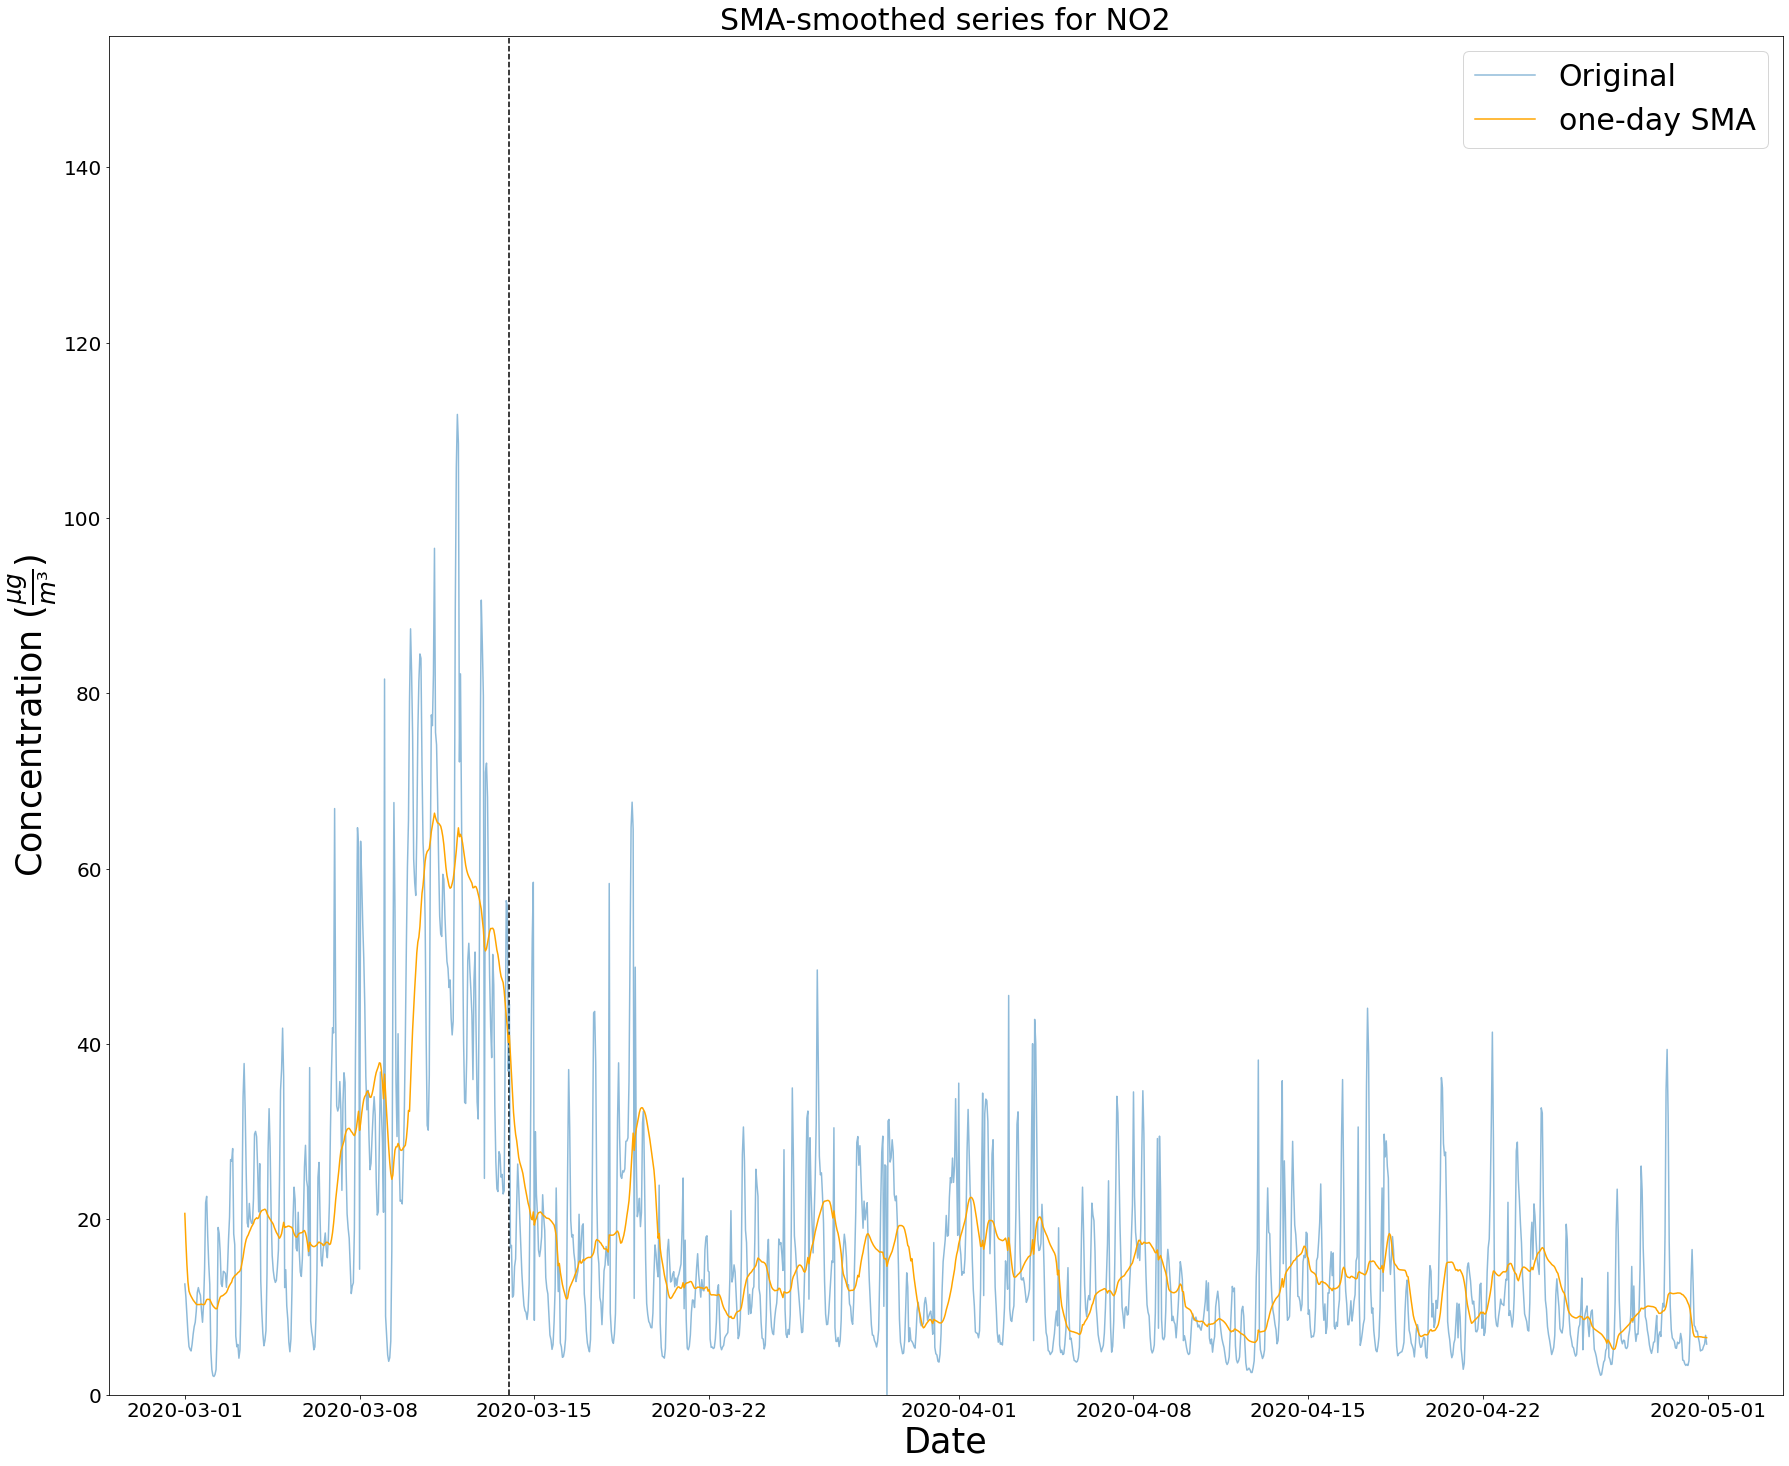

In [9]:
march1st = dt.datetime(2020,3,1)
df_after_march = df.loc[march1st:,:]
lockdown = dt.datetime(2020,3,14)

plt.figure(figsize=(30,25))
#sns.lineplot(df.index, df['concentracion'], color='blue', linestyle= ,label='original')
plt.plot(df_after_march.index, df_after_march['concentracion'].values, label='Original', alpha=0.5)
plt.plot(df_after_march.index, df_after_march['SMA'], label='one-day SMA', color='orange')
plt.xlabel('Date', fontsize=35)
plt.ylabel(r'Concentration $(\frac{\mu g}{m³})$', fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,155)
#plt.grid(color = 'black')
plt.title('SMA-smoothed series for ' + pollutant, fontsize=30)
plt.vlines(lockdown, ymin = 0, ymax = 155, linestyle='--')
plt.legend(fontsize=30);

It can be seen that pollution levels were already starting to diminish, but this decrease was accelerated when lockdown began. Furthermore, It may be possible to model this behavior as as a constant after the values have "settled down".

In [10]:
del df_after_march

In [11]:
df_bf_lock = df.loc[:lockdown]
df_aft_lock = df.loc[lockdown:]

In [12]:
df_reg = df_aft_lock.loc[dt.datetime(2020,3,21):,:]

In [13]:
df_reg['Hours_after_lockdown'] = np.arange(len(df_reg))

In [14]:
model = sm.OLS.from_formula('concentracion ~ Hours_after_lockdown', data = df_reg)
linear_reg = model.fit()
b0, b1 = linear_reg.params
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          concentracion   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     35.60
Date:                Sat, 16 May 2020   Prob (F-statistic):           3.37e-09
Time:                        13:05:35   Log-Likelihood:                -3428.3
No. Observations:                 984   AIC:                             6861.
Df Residuals:                     982   BIC:                             6870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               15.0794      0.503     29.983      0.000      14.092      16.066
Hours_after_lockdown    -0.0053      0.001     -5.967      0.000      -0.007      -0.004
==============================================================================
Omnibus:                      238.513   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              468.902
Skew:                           1.410   Prob(JB):                    1.51e-102
Kurtosis:                       4.867   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
df_reg.head()

,concentracion,SMA,Hours_after_lockdown
dt,,,
2020-03-21 00:00:00,9.818182,12.202652,0
2020-03-21 01:00:00,17.636364,12.596591,1
2020-03-21 02:00:00,8.636364,12.731061,2
2020-03-21 03:00:00,5.318182,12.768939,3
2020-03-21 04:00:00,5.136364,12.803030,4


In [16]:
df_reg['reg_values'] = b0 + b1*df_reg['Hours_after_lockdown']

In [17]:
df_reg['resid'] = df_reg['concentracion'] - df_reg['reg_values']

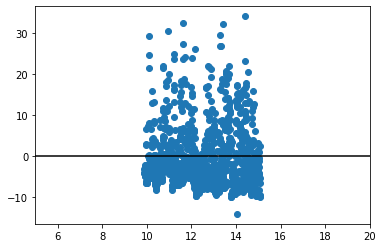

In [18]:
plt.scatter(df_reg['reg_values'].values, df_reg['resid'].values)
plt.xlim(5,20)
plt.hlines(0,5,20)

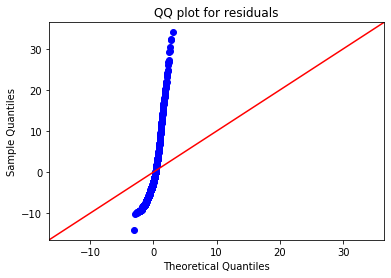

In [19]:
sm.qqplot(df_reg['resid'], line='45')
plt.title('QQ plot for residuals');

This regression was supposed to give information regarding how much the series differs from a constant after the pollutant values have settled, but although the regression and coefficients are statistically significant, the value for $R²$ and residual distributions point towards this regression not being particularly useful for concluding anything.

---

In [20]:
bf_lock_autocorr = [df_bf_lock['concentracion'].autocorr(tau) for tau in range(len(df_bf_lock))]

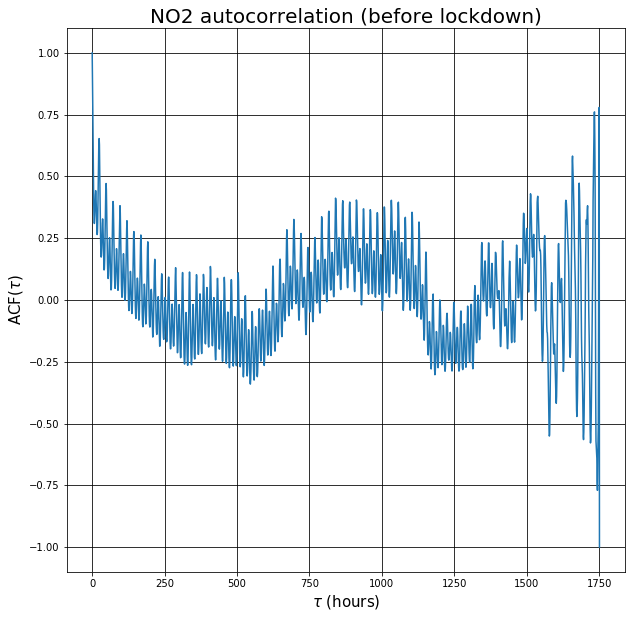

In [21]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(len(bf_lock_autocorr)), bf_lock_autocorr)
plt.grid(color='black')
plt.xlabel(r'$\tau$ (hours)', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (before lockdown)', fontsize=20);

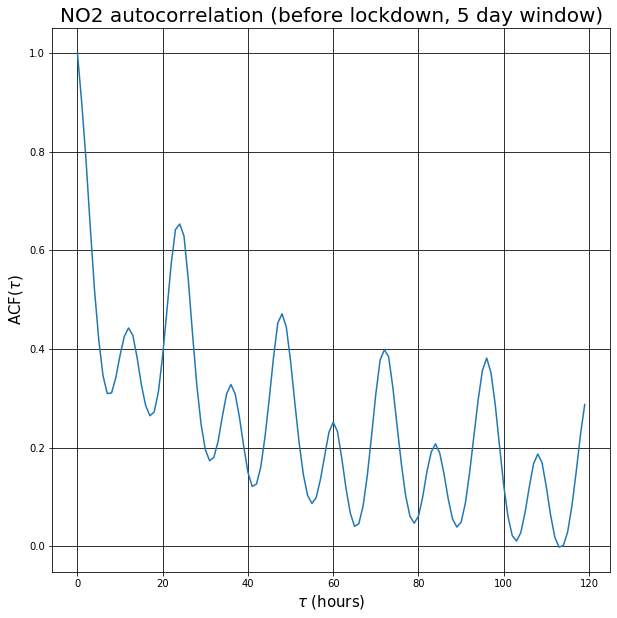

In [94]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(5*24), bf_lock_autocorr[:5*24])
plt.grid(color='black')
plt.xlabel(r'$\tau$ (hours)', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (before lockdown, 5 day window)', fontsize=20);

In [22]:
aft_lock_autocorr = [df_aft_lock['concentracion'].autocorr(tau) for tau in range(len(df_aft_lock))]

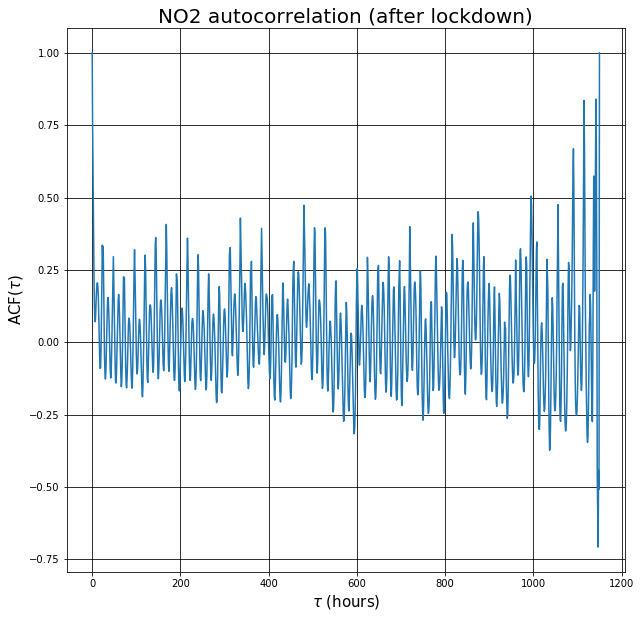

In [23]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(len(aft_lock_autocorr)), aft_lock_autocorr)
plt.grid(color='black')
plt.xlabel(r'$\tau$ (hours)', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (after lockdown)', fontsize=20);

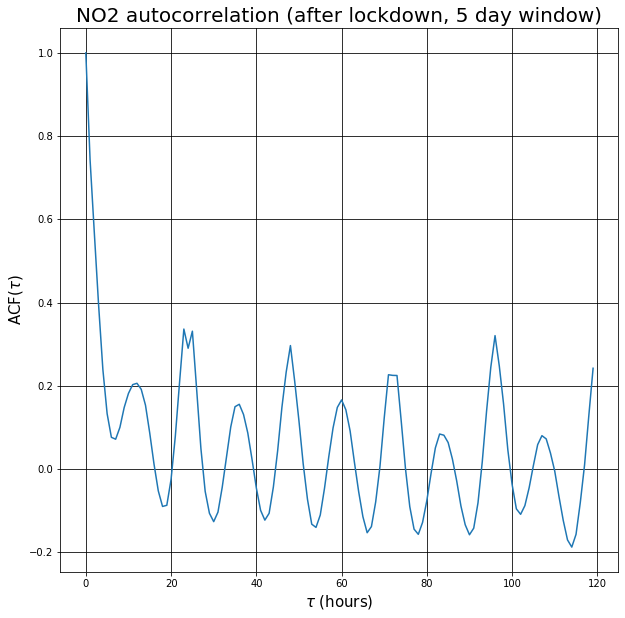

In [95]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(5*24), aft_lock_autocorr[:5*24])
plt.grid(color='black')
plt.xlabel(r'$\tau$ (hours)', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (after lockdown, 5 day window)', fontsize=20);

Comparing the behavior of the autocorrelation before and after the lockdown, it can be seen that the after series is less correlated (i.e. the values for the autocorrelation decrease faster with $\tau$) than the before series. The daily periodicity associated with the workday is largely intact, however. The weaker correlation seems to suggest a stronger random component in the after series.

In [24]:
rng = np.random.RandomState(42)
wh_noise = rng.randn(len(df_aft_lock))

In [25]:
wh_noise = pd.Series(wh_noise)
noise_autocorr = [wh_noise.autocorr(tau) for tau in range(len(wh_noise))]

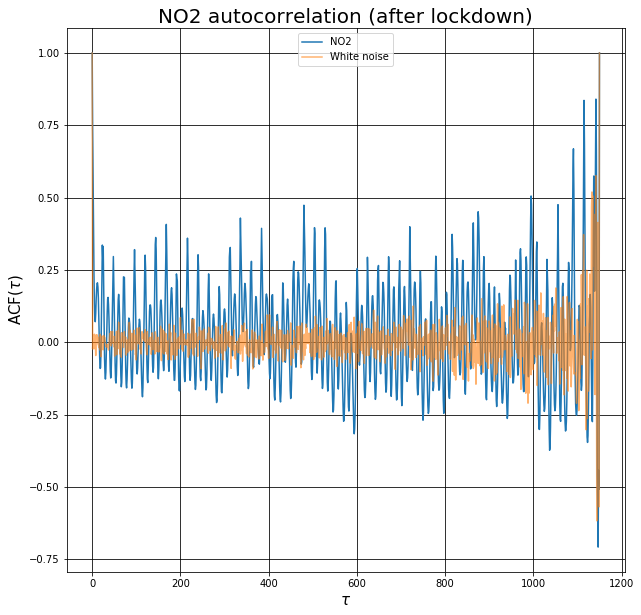

In [26]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(len(aft_lock_autocorr)), aft_lock_autocorr, label = 'NO2')
plt.plot(range(len(noise_autocorr)), noise_autocorr, label='White noise', alpha=0.6)
plt.grid(color='black')
plt.xlabel(r'$\tau$', fontsize=15)
plt.ylabel(r'ACF($\tau$)', fontsize=15)
plt.title('NO2 autocorrelation (after lockdown)', fontsize=20)
plt.legend(loc='upper center') ;

In [96]:
def brown_series(L):
    """Creates an array with values simulating brownian noise.
    Arguments:
    L: int. The length of the returned array.
    
    Returns:
    B: A NumPy array with brown noise.
    """
    
    dB = rng.randn(L) #The increments
    B = np.cumsum(dB)
    
    return B

In [97]:
br_noise = brown_series(len(aft_lock_autocorr))
br_noise = pd.Series(br_noise)
br_noise_autocorr = [br_noise.autocorr(tau) for tau in range(len(br_noise))]

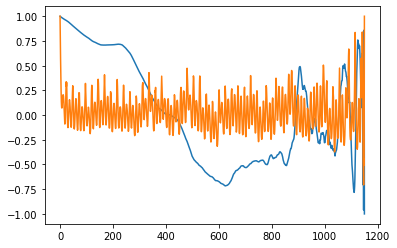

In [99]:
plt.plot(br_noise_autocorr)
plt.plot(aft_lock_autocorr)

The series appears to behave more like white than brown noise from the above, but it's still early to say for sure.

I will now be looking at the Poincaré diagram.

In [27]:
#Calculating the correlation coefficient between x_n and x_{n+1}
df_bf_lock['concentracion_shift'] = df_bf_lock['concentracion'].shift(1)
df_bf_lock[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.899711
concentracion_shift,0.899711,1.000000


The correlation is quite strong. Doing a linear regression:

In [28]:
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_bf_lock)
linear_reg = model.fit()
b0, b1 = linear_reg.params
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.809
Model:                             OLS   Adj. R-squared:                  0.809
Method:                  Least Squares   F-statistic:                     7435.
Date:                 Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                         13:05:40   Log-Likelihood:                -6693.5
No. Observations:                 1752   AIC:                         1.339e+04
Df Residuals:                     1750   BIC:                         1.340e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3472      0.524      8.293      0.000       3.319       5.375
concentracion     0.9003      0.010     86.229      0.000       0.880       0.921
==============================================================================
Omnibus:                      534.377   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8957.719
Skew:                           0.976   Prob(JB):                         0.00
Kurtosis:                      13.904   Cond. No.                         99.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

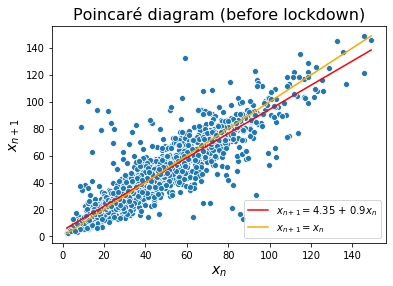

In [29]:
str_b0, str_b1 = str(round(b0,2)), str(round(b1,2))
#x_n vs x_{n+1}
df_bf_lock['concentracion_shift'] = df_bf_lock['concentracion'].shift(1)
#Line obtained above
sns.scatterplot(df_bf_lock['concentracion'],df_bf_lock['concentracion_shift'])
sns.lineplot(df_bf_lock['concentracion'], b0 + b1*df_bf_lock['concentracion'], color = 'red',
             label = r'$x_{n + 1} = $' + str_b0 + ' + ' + str_b1 + r'$x_n$')
#Identity line
sns.lineplot(df_bf_lock['concentracion'], df_bf_lock['concentracion'], 
             color='orange', label=r'$x_{n + 1} = x_n$')
plt.xlabel(r'$x_n$', fontsize=14)
plt.ylabel(r'$x_{n + 1}$', fontsize=14)
plt.title('Poincaré diagram (before lockdown)', fontsize=16);

Now after lockdown.

In [30]:
#Calculating the correlation coefficient between x_n and x_{n+1}
df_aft_lock['concentracion_shift'] = df_aft_lock['concentracion'].shift(1)
df_aft_lock[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.743114
concentracion_shift,0.743114,1.000000


The correlation is still strong, but not as much as before lockdown. Doing a linear regression:

In [31]:
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_aft_lock)
linear_reg = model.fit()
b0, b1 = linear_reg.params
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.552
Model:                             OLS   Adj. R-squared:                  0.552
Method:                  Least Squares   F-statistic:                     1417.
Date:                 Sat, 16 May 2020   Prob (F-statistic):          1.09e-202
Time:                         13:06:00   Log-Likelihood:                -3706.1
No. Observations:                 1151   AIC:                             7416.
Df Residuals:                     1149   BIC:                             7426.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4008      0.319     10.675      0.000       2.776       4.026
concentracion     0.7468      0.020     37.643      0.000       0.708       0.786
==============================================================================
Omnibus:                      639.542   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14273.962
Skew:                           2.090   Prob(JB):                         0.00
Kurtosis:                      19.738   Cond. No.                         28.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

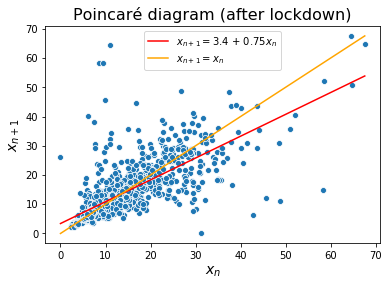

In [32]:
str_b0, str_b1 = str(round(b0,2)), str(round(b1,2))
#x_n vs x_{n+1}
df_aft_lock['concentracion_shift'] = df_aft_lock['concentracion'].shift(1)
#Line obtained above
sns.scatterplot(df_aft_lock['concentracion'],df_aft_lock['concentracion_shift'])
sns.lineplot(df_aft_lock['concentracion'], b0 + b1*df_aft_lock['concentracion'], color = 'red',
             label = r'$x_{n + 1} = $' + str_b0 + ' + ' + str_b1 + r'$x_n$')
#Identity line
sns.lineplot(df_aft_lock['concentracion'], df_aft_lock['concentracion'], 
             color='orange', label=r'$x_{n + 1} = x_n$')
plt.xlabel(r'$x_n$', fontsize=14)
plt.ylabel(r'$x_{n + 1}$', fontsize=14)
plt.title('Poincaré diagram (after lockdown)', fontsize=16);

This basically tells a similar story to the autocorrelation diagrams: before lockdown the behavior was more deterministic than random, and afterwards it's more random. Here, however, a larger deviation from white noise is observed. As can be seen from the below plot, white noise values form a roughly circular region:

In [33]:
wh_noise_shift = wh_noise.shift()

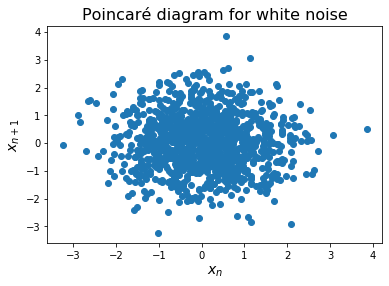

In [34]:
plt.scatter(wh_noise, wh_noise_shift)
plt.xlabel(r'$x_n$', fontsize=14)
plt.ylabel(r'$x_{n + 1}$', fontsize=14)
plt.title('Poincaré diagram for white noise', fontsize=16);

In [35]:
np.corrcoef(wh_noise[1:], wh_noise_shift[1:])

array([[ 1.        , -0.02294425],
       [-0.02294425,  1.        ]])

In [100]:
br_noise_shift = br_noise.shift()

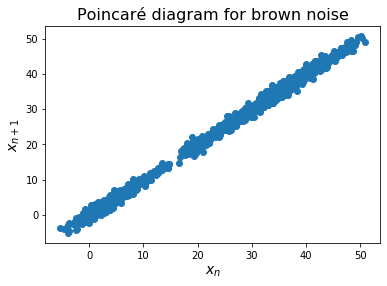

In [102]:
plt.scatter(br_noise, br_noise_shift)
plt.xlabel(r'$x_n$', fontsize=14)
plt.ylabel(r'$x_{n + 1}$', fontsize=14)
plt.title('Poincaré diagram for brown noise', fontsize=16);

In [103]:
np.corrcoef(br_noise[1:], br_noise_shift[1:])

array([[1.        , 0.99764449],
       [0.99764449, 1.        ]])

So in reality there still is some deterministic behavior after lockdown, but not as much as before.

To further explore the differences between pollutant values before and after lockdown, I'll plot histograms of the data.

In [36]:
df_bf_lock['concentracion'].describe()

count    1753.000000
mean       43.401066
std        25.292954
min         2.086957
25%        24.782609
50%        38.652174
75%        58.608696
max       149.086957
Name: concentracion, dtype: float64

In [37]:
df_aft_lock['concentracion'].describe()

count    1152.000000
mean       13.323606
std         9.052037
min         0.000000
25%         6.863636
50%        10.363636
75%        17.102273
max        67.590909
Name: concentracion, dtype: float64

In [38]:
bf_skew = np.round(df_bf_lock['concentracion'].skew(), 2)
bf_kurt = np.round(df_bf_lock['concentracion'].kurtosis(), 2)
aft_skew = np.round(df_aft_lock['concentracion'].skew(), 2)
aft_kurt = np.round(df_aft_lock['concentracion'].kurtosis(), 2)

print(f"""Skewness:
before: {bf_skew}
after: {aft_skew}

Kurtosis:
before: {bf_kurt}
after: {aft_kurt}""")

Skewness:
before: 0.82
after: 1.81

Kurtosis:
before: 0.55
after: 4.71


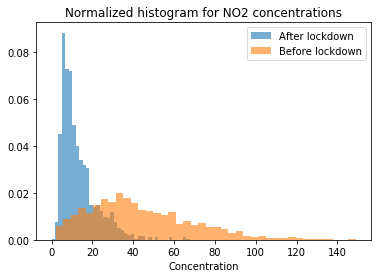

In [39]:
plt.hist(df_aft_lock['concentracion'].values, bins=40, density=True, 
         label='After lockdown', alpha=0.6)
plt.hist(df_bf_lock['concentracion'].values, bins=40, density=True,
         label='Before lockdown', alpha=0.6)
plt.xlabel('Concentration')
plt.title('Normalized histogram for %s concentrations'%(pollutant))
plt.legend();

The period before lockdown has considerably larger values of NO2 concentration, with its mean being approximately 40 $\frac{\mu g}{m^3}$ above that of the period after lockdown. The standard deviation before lockdown is also larger than after, and from the histograms it's seen that, in general, NO2 levels are more concentrated around a single small interval after lockdown than before. This can also be observed by comparing interquartile regions. The maximum values of both are also different in the same way. 

An interesting question is what happens to any seasonality that the series may have had before the lockdown. It is known that pollutant values have daily and yearly seasonalities, although for obvious reasons observing the latter here will not be possible. To check for frequencies, the Fourier transform of the data will be calculated.

In [40]:
bf_dft = np.fft.fft(df_bf_lock['concentracion'].values)
aft_dft = np.fft.fft(df_aft_lock['concentracion'].values)

N_bf = len(bf_dft)
N_aft = len(aft_dft)

In [41]:
bf_freq = np.fft.fftfreq(N_bf, 1/24) #1/24 to get frequency in 1/days
aft_freq = np.fft.fftfreq(N_aft, 1/24)

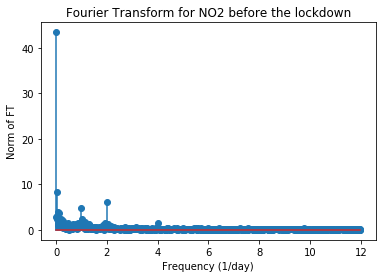

In [42]:
plt.stem(bf_freq[:N_bf//2], np.abs(bf_dft)[:N_bf//2]/N_bf)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Norm of FT')
plt.title('Fourier Transform for %s before the lockdown'%(pollutant));

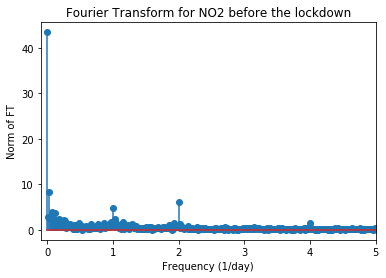

In [43]:
plt.stem(bf_freq[:N_bf//2], np.abs(bf_dft)[:N_bf//2]/N_bf)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Norm of FT')
plt.title('Fourier Transform for %s before the lockdown'%(pollutant));
plt.xlim(-0.1,5);

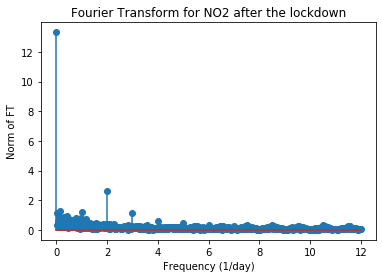

In [44]:
plt.stem(aft_freq[:N_aft//2], np.abs(aft_dft)[:N_aft//2]/N_aft)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Norm of FT')
plt.title('Fourier Transform for %s after the lockdown'%(pollutant));
#plt.xlim(-0.01,0.25)

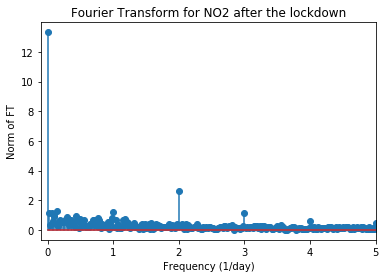

In [45]:
plt.stem(aft_freq[:N_aft//2], np.abs(aft_dft)[:N_aft//2]/N_aft)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Norm of FT')
plt.title('Fourier Transform for %s after the lockdown'%(pollutant));
plt.xlim(-0.1,5);

Plotting the power spectral density.

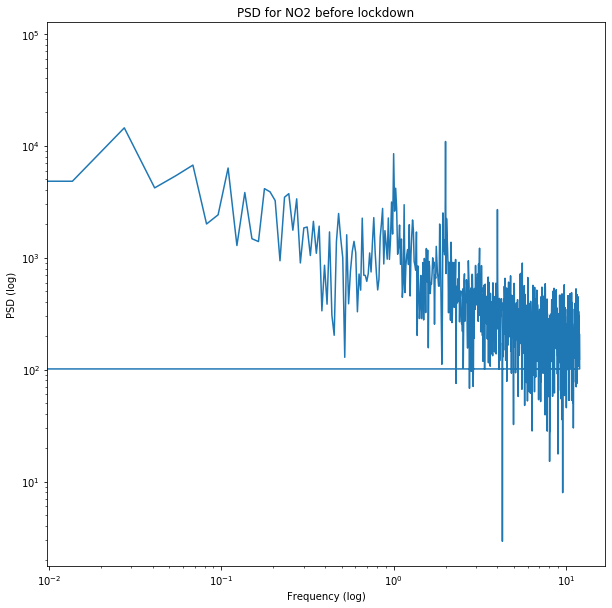

In [108]:
bf_PSD = np.abs(bf_dft)
plt.figure(figsize = (10,10))
plt.plot(bf_freq, bf_PSD)
plt.xscale('log')
plt.yscale('log')
plt.title('PSD for %s before lockdown'%(pollutant))
plt.xlabel('Frequency (log)')
plt.ylabel('PSD (log)');

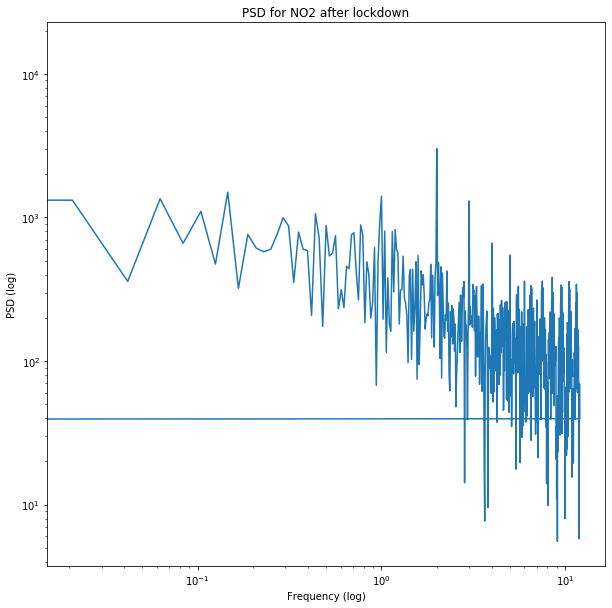

In [109]:
aft_PSD = np.abs(aft_dft)
plt.figure(figsize = (10,10))
plt.plot(aft_freq, aft_PSD)
plt.xscale('log')
plt.yscale('log')
plt.title('PSD for %s after lockdown'%(pollutant))
plt.xlabel('Frequency (log)')
plt.ylabel('PSD (log)');

I'll now check the difference between the mean pollutant levels per month before and after lockdown. 

In [46]:
mo_bf_lock_descr = df_bf_lock.groupby(df_bf_lock.index.month)['concentracion'].describe()
mo_aft_lock_descr = df_aft_lock.groupby(df_aft_lock.index.month)['concentracion'].describe()

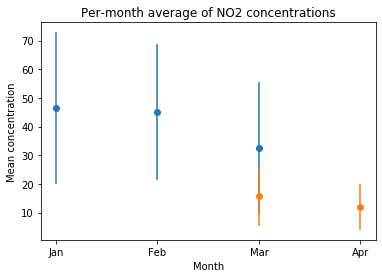

In [47]:
plt.errorbar(mo_bf_lock_descr.index, mo_bf_lock_descr['mean'], yerr=mo_bf_lock_descr['std'], 
             fmt = 'o', label='Before')
plt.errorbar(mo_aft_lock_descr.index, mo_aft_lock_descr['mean'], yerr=mo_aft_lock_descr['std'], 
             fmt = 'o', label='After')
plt.title('Per-month average of %s concentrations'%(pollutant))
plt.xlabel('Month')
plt.ylabel('Mean concentration')
plt.xticks(ticks=list(range(1,5)), labels=['Jan','Feb','Mar','Apr']);

Next I'll examine the variation on both sides with a scree diagram.

In [57]:
def traj_matrix_SVD(X, window=24):
    """Calculates the trajectory matrix and performs SVD for the scree diagram.
    Arguments:
    X: Array-like containing pollutant measurements
    window: Int. The number of rows, corresponding to a specific period of time, by default
    24 for one day.
    
    Returns:
    U, V: The left and right vectors of SVD respectively
    S: The matrix of singular values.
    """
     
    A = [] #The trajectory matrix
    col = len(X) - window #Number of columns
    for i in range(col):
        A.append(X[i:i+window])
    A = np.array(A)
    A = A.T
    
    assert A.shape == (window, col)
    
    U,S,V = np.linalg.svd(A)
    
    return U,S,V

In [81]:
U,S,V = traj_matrix_SVD(df_bf_lock['concentracion'].values)

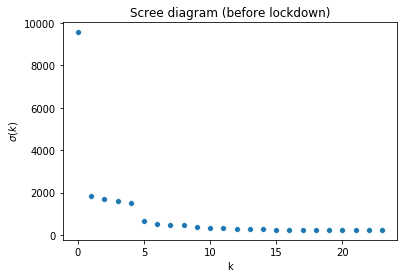

In [82]:
#S es un vector con los valores singulares. Se grafica el diagrama de scree
ax = plt.axes()
sns.scatterplot(np.arange(len(S)), S)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$\sigma(k)$')
plt.title('Scree diagram (before lockdown)');

In [85]:
U,S,V = traj_matrix_SVD(df_aft_lock['concentracion'].values)

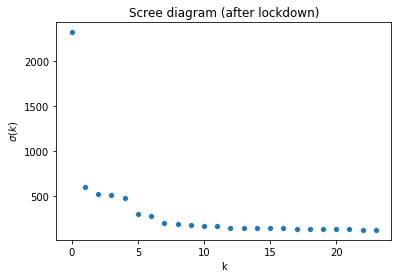

In [86]:
#S es un vector con los valores singulares. Se grafica el diagrama de scree
ax = plt.axes()
sns.scatterplot(np.arange(len(S)), S)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'$\sigma(k)$')
plt.title('Scree diagram (after lockdown)');

Plotting the spectral density 